In [0]:
import gdown
import time
import os
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import (
    Dataset, 
    DataLoader,
)
from torchvision import transforms

In [3]:
import tarfile

# https://drive.google.com/open?id=12eYPcI_3sKhOauUkUdrjzqE_ri9V0jGT
# https://drive.google.com/file/d/1lYTu5qkbHUvoIJysxxTuq5vj9H1vj7dD/view?usp=sharing

files = {
    'train': ('trainset.tar.gz', f'https://drive.google.com/uc?id=1lYTu5qkbHUvoIJysxxTuq5vj9H1vj7dD'),
    'test': ('testset.tar.gz', f'https://drive.google.com/uc?id=1kN1RZC1QjuR_U8Ttbjm_kSDfYp1cGzYn')
}

for tname, (tfname, turl) in files.items():
    if not os.path.exists(tfname):
        print(f'Downloading {tname}ing file.')
        gdown.download(turl, tfname, quiet=False)
        tar = tarfile.open(tfname, 'r:gz')
        tar.extractall()
        tar.close()
    else:
        print(f'{tname}ing file already exists.')

training file already exists.
testing file already exists.


In [0]:
class BallotPaperDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.csv_file = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.csv_file)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_name = os.path.join(self.root_dir, self.csv_file.iloc[idx, 0])

        image = io.imread(image_name)

        if self.transform:
            image = self.transform(image)

        sample = {'image': image, 'label': self.csv_file.iloc[idx, 1]}

        return sample

In [0]:
data_transform = transforms.Compose([
                                transforms.ToTensor()
    ])
ballot_dataset_train = BallotPaperDataset(csv_file='trainset.csv', root_dir='./trainset/', transform=data_transform)
ballot_dataset_test = BallotPaperDataset(csv_file='testset.csv', root_dir='./testset/', transform=data_transform)

In [0]:
def visualize_sample(dataset, n=8, ncols=4, figsize=(20, 4), random_state=None):
    nrows = int(np.ceil(n/ncols))
    fig = plt.figure(figsize=figsize)

    if random_state:
        np.random.seed(random_state)

    randints = np.random.randint(0, len(dataset), size=n)

    for i, idx in enumerate(randints):
        sample = dataset[idx]
        ax = plt.subplot(nrows, ncols, i+1)
        plt.tight_layout()
        ax.axis('off')
        ax.set_title(f'Label: {sample["label"]}')
        # print(type(sample['image']))
        plt.imshow(sample['image'].permute(1, 2, 0))
    plt.show()

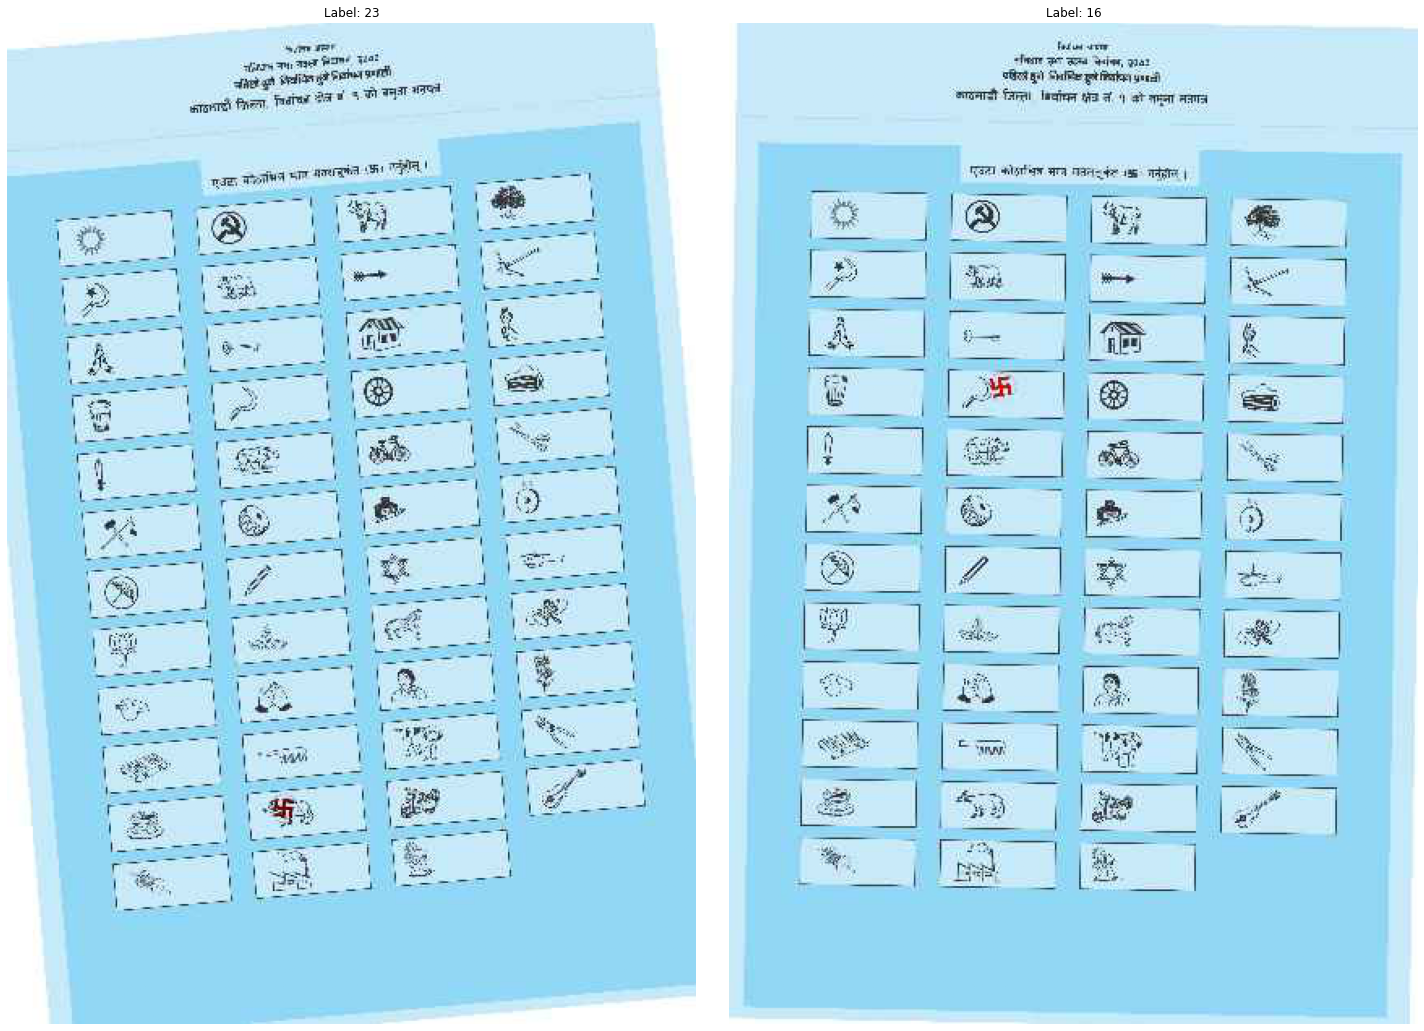

In [43]:
visualize_sample(ballot_dataset_train, n=2, ncols=2, figsize=(20, 15), random_state=19)

In [44]:
sample = ballot_dataset_test[0]
sample['image'].shape

torch.Size([3, 618, 425])

In [0]:
class BallotPaperClassifier(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=9),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=9, stride=5),
            nn.Conv2d(32, 8, kernel_size=5, stride=3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=5, stride=5),
            # nn.Conv2d(8, 4, kernel_size=5, stride=5),
            # nn.BatchNorm2d(4),
            # nn.ReLU(),
            # nn.MaxPool2d(kernel_size=5, stride=5),
            nn.Flatten(),
            nn.Linear(280, n_class),
            nn.Softmax(dim=1),
        )

    def forward(self, inp):
        out = self.cnn_layers(inp)
        return out


In [46]:
BS = 24

train_loader = DataLoader(ballot_dataset_train, batch_size=BS)
test_loader = DataLoader(ballot_dataset_test, batch_size=BS)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


In [0]:
def time_string(second):
    second_int = int(second)
    hour = second_int//(60 * 60)
    minute = (second_int - (hour * 3600))//60
    second = second % 60
    if hour > 0:
        return f'{hour:02}h:{minute:02}m:{second:02.2f}s'
    elif minute > 0:
        return f'{minute:02}m:{second:02.2f}s'
    else:
        return f'{second:02.2f}s'

In [0]:
N_EPOCHS = 5
N_CLASSES = 48

model = BallotPaperClassifier(n_class=N_CLASSES)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

for epoch in range(N_EPOCHS):
    total_loss = 0
    i_batch = 0
    total_batch = len(train_loader)
    remaining_time = 'N/A'
    time_spent = 'N/A'
    batch_start = time.time()
    batch_end = None
    for sample_batch in train_loader:
        optimizer.zero_grad()
        i_batch += 1
        if batch_end is not None:
            batch_dur = (batch_end - batch_start) / (i_batch - 1)
            remaining_time = time_string((total_batch - i_batch + 1) * batch_dur)
            time_spent = time_string(batch_end - batch_start)

        print(f'\rBatch {i_batch} of {total_batch}: {100 * i_batch/total_batch:.2f}% | Time: {time_spent} | ETA: {remaining_time}', end='')

        x_train = sample_batch['image']
        y_train = sample_batch['label']
        # print(x_train.size(), y_train.size())
        
        y_hat = model(x_train)
        # print(y_hat.size(), y_train.size())
        loss = criterion(y_hat, y_train)


        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        batch_end = time.time()

    print(f'Epoch #{epoch}, Loss: {total_loss/i_batch:.5f}')

Batch 44 of 400: 11.00% | Time: 04m:50.33s | ETA: 40m:10.42s